In [1]:
import sys
import os
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt

In [2]:
def ld_data (dir_name):
    # Load data in files from directory dir_name in a pandas dataframe
    df = pd.DataFrame()
    for filename in os.listdir(dir_name):
        funcs = []
        with open(os.path.join(dir_name, filename), 'r') as f:
            lines = f.read().splitlines()
            funcs = [line.strip().split(' ')[1][2:-1] for line in lines if not '@' in line.strip().split(' ')[1][2:-1] and not '?' in line.strip().split(' ')[1][2:-1]]

        # Concat all functions as string in df
        label = 'MALWARE' if filename.startswith('R-') else 'GOODWARE'
        df = pd.concat([df, pd.DataFrame({'filename': filename, 'label': label, 'funcs': ' '.join(funcs)}, index=[0])], ignore_index=True)
        
    return df


In [78]:
dir_name = '../data/executable-functions-test/'

In [79]:
data = ld_data(dir_name)

# Split the data into train and test
train, test = train_test_split(data, test_size=0.2)

In [80]:
# print first row of the train dataframe
print("GetCurrentThreadId" in train.iloc[0]["funcs"])

True


In [81]:
# Create the tf-idf vectorizer
vectorizer = TfidfVectorizer()
train_vectors = vectorizer.fit_transform(train['funcs']).ceil()
test_vectors = vectorizer.transform(test['funcs']).ceil()

print(vectorizer.get_feature_names_out())
print(train['filename'][0])
print(train_vectors.toarray()[0])

['___lc_codepage_func' '___lc_collate_cp_func' '___lc_handle_func' ...
 'zwsetvaluekey' 'zwunloaddriver' 'zwunmapviewofsection']
G-bitsadmin.exe
[0. 0. 0. ... 0. 0. 0.]


[Text(0.6666666666666666, 0.875, 'X[4] <= 0.5\ngini = 0.493\nsamples = 77\nvalue = [34, 43]'),
 Text(0.5, 0.625, 'X[1441] <= 0.5\ngini = 0.085\nsamples = 45\nvalue = [2, 43]'),
 Text(0.3333333333333333, 0.375, 'X[549] <= 0.5\ngini = 0.044\nsamples = 44\nvalue = [1, 43]'),
 Text(0.16666666666666666, 0.125, 'gini = 0.0\nsamples = 43\nvalue = [0, 43]'),
 Text(0.5, 0.125, 'gini = 0.0\nsamples = 1\nvalue = [1, 0]'),
 Text(0.6666666666666666, 0.375, 'gini = 0.0\nsamples = 1\nvalue = [1, 0]'),
 Text(0.8333333333333334, 0.625, 'gini = 0.0\nsamples = 32\nvalue = [32, 0]')]

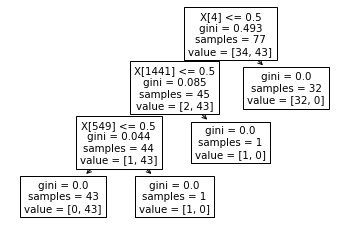

In [82]:
# Train the classifier
classifier = DecisionTreeClassifier()

classifier.fit(train_vectors, train['label'])
# Print information about the decision tree
plot_tree(classifier)

In [83]:
pred = classifier.predict(test_vectors)

# Evaluate the classifier
print('Accuracy: {}'.format(accuracy_score(test['label'], pred)))

Accuracy: 1.0


In [87]:
print(vectorizer.get_feature_names_out()[549])

disablethreadlibrarycalls
